In [9]:
import numpy as np

num_villes = 2000
num_clients = num_villes - 1  # Exclure le dépôt

def generate_weighted_adjacency_matrix(n):
    adjacency_matrix = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(i + 1, n):
            if np.random.random() < 0.8:
                weight = np.random.randint(1, 1000)
                adjacency_matrix[i][j] = weight
                adjacency_matrix[j][i] = weight
    return adjacency_matrix

matrice = generate_weighted_adjacency_matrix(num_villes)
print(matrice)


[[  0 397 229 ...   0   0 748]
 [397   0 166 ...   0 628   0]
 [229 166   0 ... 300 339 129]
 ...
 [  0   0 300 ...   0 574 396]
 [  0 628 339 ... 574   0  86]
 [748   0 129 ... 396  86   0]]


In [15]:
import numpy as np
from numpy.random import choice as np_choice
import warnings
warnings.filterwarnings("ignore")

# Évaluer la qualité des solutions
def calculer_distance_total(solution, matrice):
    distances = matrice[solution[:-1], solution[1:]]
    return np.sum(distances)

def maj_pheromone(matrice_pheromone, routes, distances):
    evaporation = 0.5

    # Évaporation des phéromones   
    matrice_pheromone *= (1 - evaporation)

    # Dépôt de phéromones sur les meilleures routes
    for route, distance in zip(routes, distances):
        pheromones = Q / distance
        matrice_pheromone[route[:-1], route[1:]] += pheromones

def maj_pheromone_intensification(matrice_pheromone, routes_visitees, intensite):
    for route in routes_visitees:
        for i in range(len(route) - 1):
            ville_actuelle = route[i]
            ville_suivante = route[i + 1]
            matrice_pheromone[ville_actuelle, ville_suivante] += intensite

def selectionner_ville(matrice_pheromone, current_ville, ville_non_visitee, alpha, beta):

    pheromone = matrice_pheromone[current_ville, ville_non_visitee]
    
    distance = matrice[current_ville, ville_non_visitee]
    
    proba = (pheromone ** alpha * (1.0 / distance) ** beta).astype(float)

    proba[distance == 0] = 0  # Gérer les distances nulles
    
    total_proba = np.sum(proba)
    if total_proba == 0:
        proba = np.ones(len(proba)) / len(proba)
    else:
        proba /= total_proba

    proba = np.maximum(proba, 0)

    next_ville_index = np_choice(len(ville_non_visitee), p=proba)
    next_ville = ville_non_visitee[next_ville_index]

    return next_ville

def vrp(matrice, num_fourmis, num_iterations, alpha, beta):
    num_ville = len(matrice)
    matrice_pheromone = np.ones((num_ville, num_ville))  # Matrice des phéromones
    best_route = None
    best_distance = float('inf')

    for i in range(num_iterations):
        routes_visitees = []  # Routes visitées par les fourmis
        routes = []
        distances = []

        for j in range(num_fourmis):
            route = [0]  # Dépôt initial
            ville_non_visitees = np.arange(1, num_ville)  # Villes non visitées
            while ville_non_visitees.size > 0:
                current_ville = route[-1]
                next_ville = selectionner_ville(matrice_pheromone, current_ville, ville_non_visitees, alpha, beta)
                route.append(next_ville)
                ville_non_visitees = np.delete(ville_non_visitees, np.where(ville_non_visitees == next_ville))

            route.append(0)  # Retour au dépôt

            if ville_non_visitees.size == 0 and route[-1] == 0:
                distance = calculer_distance_total(route, matrice)
                routes.append(route)
                distances.append(distance)

                if distance < best_distance:
                    best_route = route
                    best_distance = distance

                routes_visitees.append(route)

        maj_pheromone(matrice_pheromone, routes, distances)
        maj_pheromone_intensification(matrice_pheromone, routes_visitees, intensite)  # Intensification de la matrice de phéromone

    return best_route, best_distance

# On répartit entre le nombre de camions
def repartir_routes_optimal(route, num_camions):
    villes = route[1:-1]  # Liste des villes à répartir (excluant le dépôt)
    num_villes = len(villes)

    # Calcul de la distance totale de la route
    distance_totale = calculer_distance_total(route, matrice)

    # Calcul de la distance moyenne par camion
    distance_moyenne = distance_totale / num_camions

    camions_routes = []
    longueurs_routes = []

    camion_route = [0]  # Dépôt initial
    longueur_route = 0

    for i in range(num_villes):
        ville = villes[i]
        ville_suivante = villes[i + 1] if i < num_villes - 1 else 0  # Prochaine ville ou retour au dépôt

        # Ajout de la ville à la route actuelle
        camion_route.append(ville)
        longueur_route += matrice[ville][ville_suivante]

        # Si la longueur de la route actuelle dépasse la distance moyenne, on la termine et on commence une nouvelle route
        if longueur_route > distance_moyenne:
            camion_route.append(0)  # Retour au dépôt
            camions_routes.append(camion_route)
            longueurs_routes.append(longueur_route)

            camion_route = [0]  # Nouvelle route avec le dépôt initial
            longueur_route = 0

    # Ajout de la dernière route incomplète
    camion_route.append(0)  # Retour au dépôt
    camions_routes.append(camion_route)
    longueurs_routes.append(longueur_route)

    return camions_routes, longueurs_routes

# Paramètres de l'ACO
num_fourmis = 3
num_iterations = 15
alpha = 1.0  # Influence de la phéromone
beta = 5.0  # Influence de la visibilité   
Q = 0.2  # Quantité de phéromone déposée par les fourmis
intensite = 1.7 #intensification des pheromones
num_camions = 3  # Quantité de camions

best_route, best_distance = vrp(matrice, num_fourmis, num_iterations, alpha, beta)
camions_routes, longueurs_routes = repartir_routes_optimal(best_route, num_camions)

print("|-----------------Meilleur Global-----------------|")
print("Meilleure route:", best_route)
print("Distance totale:", best_distance)
print("|---------------Meilleur par camion---------------|")

# Affichage des routes assignées à chaque camion et de la longueur totale de chaque route
for i, route in enumerate(camions_routes):
    print(f"|------------------------{i+1}------------------------|")
    print(f"Camion {i+1} - Route : {route} ")
    print(f"Distance totale : {longueurs_routes[i]}")
    

|-----------------Meilleur Global-----------------|
Meilleure route: [0, 1481, 1521, 674, 101, 1120, 428, 1775, 1036, 1917, 754, 604, 494, 1097, 904, 857, 1586, 916, 1920, 887, 585, 1145, 503, 512, 1122, 906, 294, 849, 1405, 714, 2, 1650, 610, 557, 1839, 829, 255, 919, 424, 1369, 486, 1844, 1412, 1162, 623, 295, 1642, 1066, 1262, 238, 1083, 1760, 425, 946, 1495, 937, 1894, 315, 357, 145, 1499, 124, 1795, 501, 729, 1625, 1373, 555, 1707, 1016, 394, 531, 1889, 498, 72, 825, 1793, 1487, 1354, 579, 1488, 656, 974, 1630, 842, 442, 603, 408, 1391, 1134, 796, 662, 576, 1651, 1861, 625, 629, 1172, 1982, 1382, 1329, 649, 694, 1161, 1149, 949, 834, 53, 1185, 1355, 1835, 1933, 1203, 1551, 571, 1341, 1854, 797, 1342, 1881, 751, 1115, 1963, 126, 964, 395, 905, 720, 636, 711, 107, 840, 1841, 1064, 1876, 1649, 1716, 322, 1766, 641, 169, 1732, 123, 1182, 772, 1040, 1528, 422, 152, 569, 1823, 52, 1810, 1132, 244, 696, 1444, 620, 1106, 746, 1459, 539, 1103, 1367, 1714, 1938, 1731, 365, 899, 1348, 458, 6

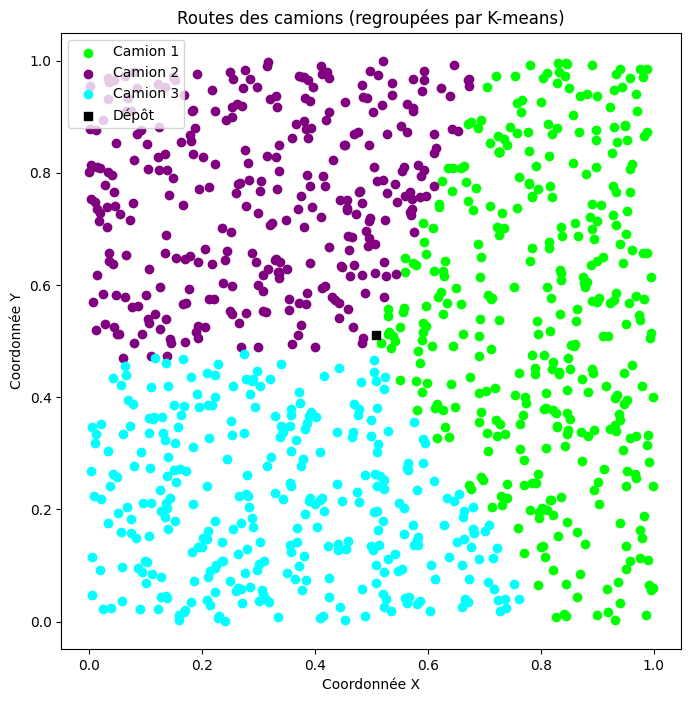

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

# Définition des couleurs pour chaque camion
colors = ['lime', 'purple', 'cyan', 'red', 'yellow', 'y', 'k']

# Génération de coordonnées aléatoires pour chaque ville
coord_villes = np.random.rand(num_villes, 2)

# Coordonnées du dépôt initial
depot_coord = np.mean(coord_villes, axis=0)

# Nombre de clusters (basé sur le nombre de camions)
num_clusters = num_camions

# Calcul des coordonnées des centres de chaque cluster
cluster_centers = []
radius = 0.4 * np.sqrt(num_clusters)  # Rayon du cercle autour du dépôt
for i in range(num_clusters):
    angle = 2 * np.pi * i / num_clusters
    x = depot_coord[0] + radius * np.cos(angle)
    y = depot_coord[1] + radius * np.sin(angle)
    cluster_centers.append([x, y])

# Création des clusters pour chaque route de camion
clusters = [[] for _ in range(num_camions)]

for i, route in enumerate(camions_routes):
    cluster = clusters[i]
    for ville in route:
        coord = coord_villes[ville]
        cluster.append(coord)

# Concaténation des coordonnées des points pour l'algorithme K-means
points = np.concatenate(clusters)

# Ajout des coordonnées du dépôt aux points
points = np.vstack((points, depot_coord))

# Application de l'algorithme K-means
kmeans = KMeans(n_clusters=num_clusters, random_state=0, init=np.array(cluster_centers))
labels = kmeans.fit_predict(points[:-1])  # Exclure les coordonnées du dépôt

# Création du graphique
plt.figure(figsize=(8, 8))

# Parcours des points par label de cluster
for label in range(num_clusters):
    # Filtre des indices des points pour le cluster actuel
    cluster_indices = np.where(labels == label)[0]

    # Filtre des points pour le cluster actuel
    cluster_points = points[cluster_indices]

    # Récupération des coordonnées x et y pour chaque point
    x = cluster_points[:, 0]
    y = cluster_points[:, 1]

    # Tracé des points avec une couleur aléatoire pour chaque cluster
    color = colors[label]
    plt.scatter(x, y, color=color, label=f'Camion {label + 1}')

# Ajout du dépôt initial
plt.scatter(depot_coord[0], depot_coord[1], color='k', marker='s', label='Dépôt')

# Affichage des légendes
plt.legend()

# Paramètres d'affichage
plt.title('Routes des camions (regroupées par K-means)')
plt.xlabel('Coordonnée X')
plt.ylabel('Coordonnée Y')

# Affichage du graphique
plt.show()
